In [4]:
import os
import glob
import random
import mne
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger('mne').setLevel(logging.WARNING)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

# Data path
data_path = '/kaggle/input/spectrogram-extended-1'
batch_size = 16
num_classes = 4
learning_rate = 1e-3
n_epochs = 50

# ----------------------------------------
# Custom Dataset for Spectrogram Images
# ----------------------------------------
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, train_ratio=0.8, shuffle=True):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all jpg files
        self.all_files = glob.glob(os.path.join(root_dir, '*.jpg'))

        if shuffle:
            random.shuffle(self.all_files)

        # Train/val split
        train_size = int(len(self.all_files) * train_ratio)
        if train:
            self.files = self.all_files[:train_size]
        else:
            self.files = self.all_files[train_size:]
        
        # Mapping from label substring to integer
        self.class_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        filename = os.path.basename(img_path)

        # Extract label (G1, G2, G3, G4)
        g_index = filename.find('G')
        label_str = filename[g_index:g_index+2]  # e.g. 'G1'
        label = self.class_map[label_str]

        from PIL import Image
        image = Image.open(img_path).convert('L')  # convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label


# ----------------------------------------
# Transforms
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and dataloaders
train_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform, train=True, train_ratio=0.8)
test_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform, train=False, train_ratio=0.8)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Quick sanity check
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)  # [batch_size, 1, 128, 128]
    print("Targets shape:", targets.shape)
    break

# ----------------------------------------
# CNN Model Definition
# ----------------------------------------
class MyEEGCNNModel(nn.Module):
    def __init__(self, n_outputs):
        super(MyEEGCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 64, kernel_size=5)
        # After conv1 (5x5): output size -> 124x124 (from 128x128)
        # max pool (2x2) -> 62x62
        # After conv2 (5x5): output size -> 58x58
        # max pool (2x2) -> 29x29
        # final feature map: 64 x 29 x 29
        self.fc1 = nn.Linear(64 * 29 * 29, n_outputs)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x


model = MyEEGCNNModel(num_classes).to(device)

# Test forward pass for shape
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    out = model(inputs)
    print("Output shape:", out.shape)  # [batch_size, num_classes]
    break

# ----------------------------------------
# Accuracy Function
# ----------------------------------------
def accuracy(data_loader, model):
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        return correct / total

# ----------------------------------------
# Training Setup
# ----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

loss_history = []
acc_history = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy(train_loader, model)
    val_acc = accuracy(test_loader, model)
    loss_history.append(train_loss)
    acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Input shape: torch.Size([16, 1, 128, 128])
Targets shape: torch.Size([16])
Output shape: torch.Size([16, 4])


100%|██████████| 117/117 [00:10<00:00, 10.95it/s]


Epoch [1/50], Loss: 1.4025, Train Acc: 0.3216, Val Acc: 0.3017


100%|██████████| 117/117 [00:09<00:00, 11.90it/s]


Epoch [2/50], Loss: 1.3673, Train Acc: 0.3996, Val Acc: 0.3685


100%|██████████| 117/117 [00:09<00:00, 11.84it/s]


Epoch [3/50], Loss: 1.3097, Train Acc: 0.4589, Val Acc: 0.4418


100%|██████████| 117/117 [00:09<00:00, 11.76it/s]


Epoch [4/50], Loss: 1.2485, Train Acc: 0.5091, Val Acc: 0.4634


100%|██████████| 117/117 [00:09<00:00, 11.91it/s]


Epoch [5/50], Loss: 1.1972, Train Acc: 0.5379, Val Acc: 0.4978


100%|██████████| 117/117 [00:09<00:00, 11.86it/s]


Epoch [6/50], Loss: 1.1445, Train Acc: 0.5598, Val Acc: 0.4978


100%|██████████| 117/117 [00:10<00:00, 11.66it/s]


Epoch [7/50], Loss: 1.1008, Train Acc: 0.5743, Val Acc: 0.5280


100%|██████████| 117/117 [00:09<00:00, 11.82it/s]


Epoch [8/50], Loss: 1.0303, Train Acc: 0.6245, Val Acc: 0.5948


100%|██████████| 117/117 [00:10<00:00, 11.67it/s]


Epoch [9/50], Loss: 0.9632, Train Acc: 0.6651, Val Acc: 0.6250


100%|██████████| 117/117 [00:10<00:00, 11.15it/s]


Epoch [10/50], Loss: 0.9055, Train Acc: 0.6950, Val Acc: 0.6379


100%|██████████| 117/117 [00:10<00:00, 11.61it/s]


Epoch [11/50], Loss: 0.8491, Train Acc: 0.7078, Val Acc: 0.6379


100%|██████████| 117/117 [00:10<00:00, 11.67it/s]


Epoch [12/50], Loss: 0.7881, Train Acc: 0.7628, Val Acc: 0.6918


100%|██████████| 117/117 [00:10<00:00, 11.52it/s]


Epoch [13/50], Loss: 0.7347, Train Acc: 0.7666, Val Acc: 0.6918


100%|██████████| 117/117 [00:09<00:00, 11.91it/s]


Epoch [14/50], Loss: 0.6975, Train Acc: 0.7975, Val Acc: 0.7392


100%|██████████| 117/117 [00:10<00:00, 11.67it/s]


Epoch [15/50], Loss: 0.6587, Train Acc: 0.8168, Val Acc: 0.7392


100%|██████████| 117/117 [00:09<00:00, 11.92it/s]


Epoch [16/50], Loss: 0.6232, Train Acc: 0.8184, Val Acc: 0.7284


100%|██████████| 117/117 [00:10<00:00, 11.42it/s]


Epoch [17/50], Loss: 0.5897, Train Acc: 0.8376, Val Acc: 0.7414


100%|██████████| 117/117 [00:10<00:00, 11.16it/s]


Epoch [18/50], Loss: 0.5525, Train Acc: 0.8526, Val Acc: 0.7888


100%|██████████| 117/117 [00:10<00:00, 11.47it/s]


Epoch [19/50], Loss: 0.5349, Train Acc: 0.8606, Val Acc: 0.7802


100%|██████████| 117/117 [00:10<00:00, 11.32it/s]


Epoch [20/50], Loss: 0.4980, Train Acc: 0.8809, Val Acc: 0.8103


100%|██████████| 117/117 [00:10<00:00, 11.28it/s]


Epoch [21/50], Loss: 0.4590, Train Acc: 0.8686, Val Acc: 0.7823


100%|██████████| 117/117 [00:10<00:00, 11.16it/s]


Epoch [22/50], Loss: 0.4519, Train Acc: 0.9012, Val Acc: 0.8103


100%|██████████| 117/117 [00:10<00:00, 11.09it/s]


Epoch [23/50], Loss: 0.4269, Train Acc: 0.8921, Val Acc: 0.8211


100%|██████████| 117/117 [00:10<00:00, 11.43it/s]


Epoch [24/50], Loss: 0.4003, Train Acc: 0.8835, Val Acc: 0.8190


100%|██████████| 117/117 [00:10<00:00, 11.37it/s]


Epoch [25/50], Loss: 0.3682, Train Acc: 0.9172, Val Acc: 0.8297


100%|██████████| 117/117 [00:10<00:00, 10.92it/s]


Epoch [26/50], Loss: 0.3610, Train Acc: 0.9135, Val Acc: 0.8190


100%|██████████| 117/117 [00:10<00:00, 11.32it/s]


Epoch [27/50], Loss: 0.3333, Train Acc: 0.9263, Val Acc: 0.8556


100%|██████████| 117/117 [00:10<00:00, 11.26it/s]


Epoch [28/50], Loss: 0.3065, Train Acc: 0.9151, Val Acc: 0.8233


100%|██████████| 117/117 [00:09<00:00, 11.83it/s]


Epoch [29/50], Loss: 0.2972, Train Acc: 0.9327, Val Acc: 0.8491


100%|██████████| 117/117 [00:09<00:00, 11.79it/s]


Epoch [30/50], Loss: 0.2785, Train Acc: 0.9503, Val Acc: 0.8707


100%|██████████| 117/117 [00:10<00:00, 11.56it/s]


Epoch [31/50], Loss: 0.2709, Train Acc: 0.9375, Val Acc: 0.8556


100%|██████████| 117/117 [00:09<00:00, 12.00it/s]


Epoch [32/50], Loss: 0.2597, Train Acc: 0.9546, Val Acc: 0.8750


100%|██████████| 117/117 [00:10<00:00, 11.67it/s]


Epoch [33/50], Loss: 0.2438, Train Acc: 0.9375, Val Acc: 0.8621


100%|██████████| 117/117 [00:10<00:00, 11.32it/s]


Epoch [34/50], Loss: 0.2234, Train Acc: 0.9589, Val Acc: 0.8815


100%|██████████| 117/117 [00:10<00:00, 11.66it/s]


Epoch [35/50], Loss: 0.2046, Train Acc: 0.9557, Val Acc: 0.8772


100%|██████████| 117/117 [00:10<00:00, 11.62it/s]


Epoch [36/50], Loss: 0.2069, Train Acc: 0.9599, Val Acc: 0.8901


100%|██████████| 117/117 [00:10<00:00, 11.37it/s]


Epoch [37/50], Loss: 0.1822, Train Acc: 0.9712, Val Acc: 0.8901


100%|██████████| 117/117 [00:10<00:00, 11.24it/s]


Epoch [38/50], Loss: 0.1821, Train Acc: 0.9733, Val Acc: 0.8879


100%|██████████| 117/117 [00:10<00:00, 11.56it/s]


Epoch [39/50], Loss: 0.1490, Train Acc: 0.9679, Val Acc: 0.8901


100%|██████████| 117/117 [00:09<00:00, 11.73it/s]


Epoch [40/50], Loss: 0.1359, Train Acc: 0.9813, Val Acc: 0.8987


100%|██████████| 117/117 [00:09<00:00, 11.89it/s]


Epoch [41/50], Loss: 0.1428, Train Acc: 0.9605, Val Acc: 0.8879


100%|██████████| 117/117 [00:10<00:00, 11.52it/s]


Epoch [42/50], Loss: 0.1331, Train Acc: 0.9712, Val Acc: 0.8858


100%|██████████| 117/117 [00:09<00:00, 11.82it/s]


Epoch [43/50], Loss: 0.1421, Train Acc: 0.9829, Val Acc: 0.9073


100%|██████████| 117/117 [00:09<00:00, 12.01it/s]


Epoch [44/50], Loss: 0.1110, Train Acc: 0.9909, Val Acc: 0.9030


100%|██████████| 117/117 [00:09<00:00, 11.70it/s]


Epoch [45/50], Loss: 0.1269, Train Acc: 0.9781, Val Acc: 0.8879


100%|██████████| 117/117 [00:09<00:00, 11.86it/s]


Epoch [46/50], Loss: 0.1024, Train Acc: 0.9818, Val Acc: 0.9030


100%|██████████| 117/117 [00:10<00:00, 11.66it/s]


Epoch [47/50], Loss: 0.1004, Train Acc: 0.9845, Val Acc: 0.8944


100%|██████████| 117/117 [00:09<00:00, 11.86it/s]


Epoch [48/50], Loss: 0.1033, Train Acc: 0.9904, Val Acc: 0.9030


100%|██████████| 117/117 [00:09<00:00, 11.85it/s]


Epoch [49/50], Loss: 0.0825, Train Acc: 0.9760, Val Acc: 0.8858


100%|██████████| 117/117 [00:10<00:00, 11.53it/s]


Epoch [50/50], Loss: 0.0827, Train Acc: 0.9931, Val Acc: 0.9116


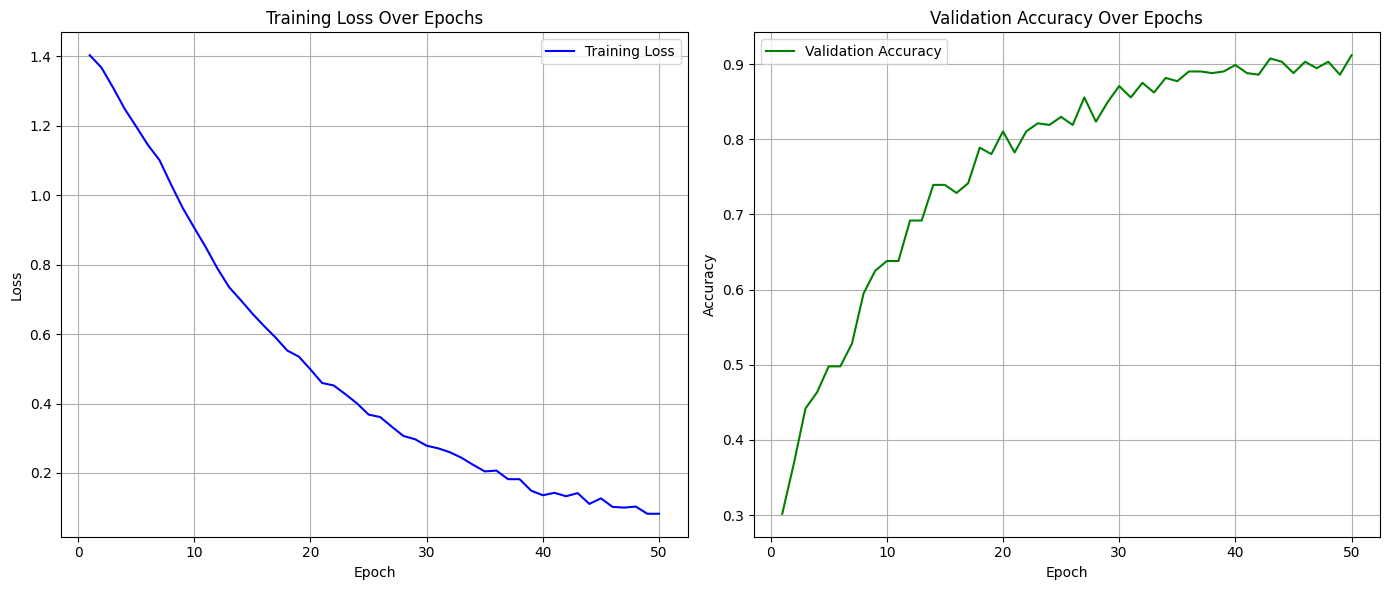

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'loss_history' and 'acc_history' are defined
n_epochs = 50  # Total number of epochs

epochs = np.arange(1, n_epochs + 1)

# Plotting training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot for validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


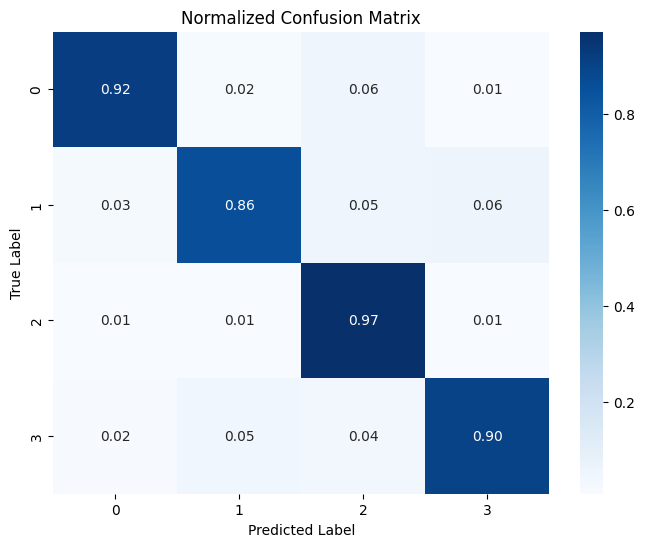

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and actual labels
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [8]:
!pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.0 MB/s eta 0:00:0000:01


In [9]:
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import snntorch as snn
import torch.nn as nn
import torch.nn.functional as F
from snntorch import surrogate, utils
import snntorch.functional as SF
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data path
data_path = '/kaggle/input/spectrogram-extended-1'
batch_size = 32
num_classes = 4
x = 100
num_steps = 20
beta = 0.3
spike_grad = surrogate.fast_sigmoid(slope=10)
learning_rate = 1e-3
n_epochs = x

# Custom Dataset for Spectrogram Images
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all jpg files
        self.all_files = glob.glob(os.path.join(root_dir, '*.jpg'))

        # Mapping from label substring to integer
        self.class_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path = self.all_files[idx]

        # Extract label from filename
        filename = os.path.basename(img_path)
        g_index = filename.find('G')
        label_str = filename[g_index:g_index+2]  # e.g. 'G1'
        label = self.class_map[label_str]

        image = Image.open(img_path).convert('L')  # convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label


# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the entire dataset
full_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform)

# Determine the size of the training and testing sets (80% / 20% split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split dataset into training and testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Quick sanity check
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)  # [batch_size, 1, 128, 128]
    print("Targets shape:", targets.shape)
    break


# ----------------------------------------
# Model Definition
# Update fc1 input dimension after conv/pool
# ----------------------------------------
class MyEEGSNNModel(nn.Module):
    def __init__(self, n_outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        # Assuming input 128x128:
        # After first conv (5x5) => 124x124, max pool (2x2) => 62x62
        # After second conv (5x5) => 58x58, max pool (2x2) => 29x29
        # So final feature map size: 64 x 29 x 29
        # Thus fc1 in_features = 64 * 29 * 29
        self.fc1 = nn.Linear(64 * 29 * 29, n_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), kernel_size=(2, 2))
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), kernel_size=(2, 2))
        spk2, mem2 = self.lif2(cur2, mem2)

        # Flatten
        batch_size_curr = x.shape[0]
        cur3 = self.fc1(spk2.view(batch_size_curr, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3


# Instantiate model and verify forward pass
model = MyEEGSNNModel(num_classes).to(device)
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    spk_rec, mem_rec = utils.reset(model), None
    # Quick forward pass for shape check:
    spk_test, mem_test = model(inputs)
    print("Output spk shape:", spk_test.shape)  # Should be [batch_size, num_classes]
    break


# ----------------------------------------
# Forward pass over multiple timesteps
# ----------------------------------------
def forward_pass(input_data, model, num_steps):
    spk_rec = []
    mem_rec = []
    utils.reset(model)
    for i in range(num_steps):
        spk, mem = model(input_data)
        spk_rec.append(spk)
        mem_rec.append(mem)
    return torch.stack(spk_rec), torch.stack(mem_rec)


def batch_acc(data_loader, model, num_steps):
    with torch.no_grad():
        model.eval()
        acc = 0
        total = 0
        for inputs, targets in iter(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            spk_rec, mem_rec = forward_pass(inputs, model, num_steps)
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
    return acc / total


# ----------------------------------------
# Training Setup
# ----------------------------------------
criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

loss_history = []
acc_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    counter = 0
    acc_co = 0
    
    model.train()
    for inputs, targets in tqdm(iter(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        spk_rec, _ = forward_pass(inputs, model, num_steps)
        loss = criterion(spk_rec, targets)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        counter += 1

        # Periodically check accuracy on test set
        if counter % 10 == 0:  # adjust frequency as needed
            acc_val = batch_acc(test_loader, model, num_steps)
            train_acc += acc_val
            acc_co += 1

    train_loss = epoch_loss / counter
    train_acc = (train_acc / acc_co) if acc_co > 0 else 0
    loss_history.append(train_loss)
    acc_history.append(train_acc)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')


Input shape: torch.Size([32, 1, 128, 128])
Targets shape: torch.Size([32])
Output spk shape: torch.Size([32, 4])


100%|██████████| 58/58 [00:33<00:00,  1.73it/s]


Epoch [1/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


Epoch [2/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [3/100], Loss: 1.3870, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [4/100], Loss: 1.3849, Accuracy: 0.2683


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [5/100], Loss: 1.3851, Accuracy: 0.2679


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [6/100], Loss: 1.3858, Accuracy: 0.2638


100%|██████████| 58/58 [00:33<00:00,  1.74it/s]


Epoch [7/100], Loss: 1.3847, Accuracy: 0.2643


100%|██████████| 58/58 [00:33<00:00,  1.72it/s]


Epoch [8/100], Loss: 1.3831, Accuracy: 0.2638


100%|██████████| 58/58 [00:34<00:00,  1.70it/s]


Epoch [9/100], Loss: 1.3826, Accuracy: 0.2679


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [10/100], Loss: 1.3821, Accuracy: 0.2786


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [11/100], Loss: 1.3878, Accuracy: 0.2692


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [12/100], Loss: 1.4296, Accuracy: 0.2848


100%|██████████| 58/58 [00:33<00:00,  1.73it/s]


Epoch [13/100], Loss: 1.3867, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [14/100], Loss: 1.3878, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [15/100], Loss: 1.3857, Accuracy: 0.2696


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [16/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [17/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [18/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [19/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [20/100], Loss: 1.3863, Accuracy: 0.2665


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [21/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [22/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:31<00:00,  1.81it/s]


Epoch [23/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [24/100], Loss: 1.3863, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [25/100], Loss: 1.3788, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [26/100], Loss: 1.4618, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [27/100], Loss: 1.3897, Accuracy: 0.2670


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [28/100], Loss: 1.3853, Accuracy: 0.2665


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [29/100], Loss: 1.3823, Accuracy: 0.2705


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [30/100], Loss: 1.3816, Accuracy: 0.2732


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [31/100], Loss: 1.3858, Accuracy: 0.2656


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [32/100], Loss: 1.3856, Accuracy: 0.2656


 67%|██████▋   | 39/58 [00:23<00:11,  1.64it/s]


KeyboardInterrupt: 

In [14]:
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import snntorch as snn
import torch.nn as nn
import torch.nn.functional as F
from snntorch import surrogate, utils
import snntorch.functional as SF
from tqdm import tqdm

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # For CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data path
data_path = '/kaggle/input/spectrogram-extended-1'
batch_size = 32
num_classes = 4
x = 100
num_steps = 20
beta = 0.3
spike_grad = surrogate.fast_sigmoid(slope=10)
learning_rate = 1e-3
n_epochs = x

# Custom Dataset for Spectrogram Images
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all jpg files
        self.all_files = glob.glob(os.path.join(root_dir, '*.jpg'))

        # Mapping from label substring to integer
        self.class_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path = self.all_files[idx]

        # Extract label from filename
        filename = os.path.basename(img_path)
        g_index = filename.find('G')
        label_str = filename[g_index:g_index+2]  # e.g. 'G1'
        label = self.class_map[label_str]

        image = Image.open(img_path).convert('L')  # convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label


# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the entire dataset
full_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform)

# Determine the size of the training and testing sets (80% / 20% split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split dataset into training and testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Quick sanity check
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)  # [batch_size, 1, 128, 128]
    print("Targets shape:", targets.shape)
    break


# ----------------------------------------
# Model Definition
# Update fc1 input dimension after conv/pool
# ----------------------------------------
class MyEEGSNNModel(nn.Module):
    def __init__(self, n_outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        # Assuming input 128x128:
        # After first conv (5x5) => 124x124, max pool (2x2) => 62x62
        # After second conv (5x5) => 58x58, max pool (2x2) => 29x29
        # So final feature map size: 64 x 29 x 29
        # Thus fc1 in_features = 64 * 29 * 29
        self.fc1 = nn.Linear(64 * 29 * 29, n_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), kernel_size=(2, 2))
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), kernel_size=(2, 2))
        spk2, mem2 = self.lif2(cur2, mem2)

        # Flatten
        batch_size_curr = x.shape[0]
        cur3 = self.fc1(spk2.view(batch_size_curr, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3


# Instantiate model and verify forward pass
model = MyEEGSNNModel(num_classes).to(device)
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    spk_rec, mem_rec = utils.reset(model), None
    # Quick forward pass for shape check:
    spk_test, mem_test = model(inputs)
    print("Output spk shape:", spk_test.shape)  # Should be [batch_size, num_classes]
    break


# ----------------------------------------
# Forward pass over multiple timesteps
# ----------------------------------------
def forward_pass(input_data, model, num_steps):
    spk_rec = []
    mem_rec = []
    utils.reset(model)
    for i in range(num_steps):
        spk, mem = model(input_data)
        spk_rec.append(spk)
        mem_rec.append(mem)
    return torch.stack(spk_rec), torch.stack(mem_rec)


def batch_acc(data_loader, model, num_steps):
    with torch.no_grad():
        model.eval()
        acc = 0
        total = 0
        for inputs, targets in iter(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            spk_rec, mem_rec = forward_pass(inputs, model, num_steps)
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
    return acc / total


# ----------------------------------------
# Training Setup
# ----------------------------------------
criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

loss_history = []
acc_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    counter = 0
    acc_co = 0
    
    model.train()
    for inputs, targets in tqdm(iter(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        spk_rec, _ = forward_pass(inputs, model, num_steps)
        loss = criterion(spk_rec, targets)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        counter += 1

        # Periodically check accuracy on test set
        if counter % 10 == 0:  # adjust frequency as needed
            acc_val = batch_acc(test_loader, model, num_steps)
            train_acc += acc_val
            acc_co += 1

    train_loss = epoch_loss / counter
    train_acc = (train_acc / acc_co) if acc_co > 0 else 0
    loss_history.append(train_loss)
    acc_history.append(train_acc)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')


Input shape: torch.Size([32, 1, 128, 128])
Targets shape: torch.Size([32])
Output spk shape: torch.Size([32, 4])


100%|██████████| 58/58 [00:33<00:00,  1.74it/s]


Epoch [1/100], Loss: 1.3863, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [2/100], Loss: 1.3863, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [3/100], Loss: 1.3863, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [4/100], Loss: 1.3863, Accuracy: 0.2254


100%|██████████| 58/58 [00:33<00:00,  1.73it/s]


Epoch [5/100], Loss: 1.3863, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [6/100], Loss: 1.3863, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [7/100], Loss: 1.3882, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [8/100], Loss: 1.4008, Accuracy: 0.2366


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [9/100], Loss: 1.3769, Accuracy: 0.2362


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [10/100], Loss: 1.3939, Accuracy: 0.2460


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [11/100], Loss: 1.3756, Accuracy: 0.2286


100%|██████████| 58/58 [00:32<00:00,  1.81it/s]


Epoch [12/100], Loss: 1.4004, Accuracy: 0.2750


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [13/100], Loss: 1.4224, Accuracy: 0.3000


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [14/100], Loss: 1.4174, Accuracy: 0.2277


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [15/100], Loss: 1.4827, Accuracy: 0.2643


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [16/100], Loss: 1.4674, Accuracy: 0.2799


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [17/100], Loss: 1.4662, Accuracy: 0.2812


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [18/100], Loss: 1.4688, Accuracy: 0.2812


100%|██████████| 58/58 [00:33<00:00,  1.71it/s]


Epoch [19/100], Loss: 1.4681, Accuracy: 0.2812


100%|██████████| 58/58 [00:33<00:00,  1.74it/s]


Epoch [20/100], Loss: 1.4668, Accuracy: 0.2812


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [21/100], Loss: 1.4512, Accuracy: 0.2710


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]


Epoch [22/100], Loss: 1.4461, Accuracy: 0.2263


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [23/100], Loss: 1.4208, Accuracy: 0.2460


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]


Epoch [24/100], Loss: 1.3875, Accuracy: 0.2339


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [25/100], Loss: 1.3856, Accuracy: 0.2308


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [26/100], Loss: 1.3848, Accuracy: 0.2263


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [27/100], Loss: 1.3851, Accuracy: 0.2259


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [28/100], Loss: 1.3848, Accuracy: 0.2299


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [29/100], Loss: 1.3875, Accuracy: 0.2411


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [30/100], Loss: 1.4057, Accuracy: 0.2763


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [31/100], Loss: 1.3949, Accuracy: 0.2634


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [32/100], Loss: 1.3851, Accuracy: 0.2313


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [33/100], Loss: 1.3912, Accuracy: 0.2571


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [34/100], Loss: 1.3840, Accuracy: 0.2500


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [35/100], Loss: 1.3802, Accuracy: 0.2478


100%|██████████| 58/58 [00:32<00:00,  1.81it/s]


Epoch [36/100], Loss: 1.3790, Accuracy: 0.2406


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [37/100], Loss: 1.3797, Accuracy: 0.2460


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [38/100], Loss: 1.3835, Accuracy: 0.2286


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [39/100], Loss: 1.3805, Accuracy: 0.2339


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [40/100], Loss: 1.3831, Accuracy: 0.2277


100%|██████████| 58/58 [00:32<00:00,  1.77it/s]


Epoch [41/100], Loss: 1.3826, Accuracy: 0.2304


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [42/100], Loss: 1.3774, Accuracy: 0.2348


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [43/100], Loss: 1.3740, Accuracy: 0.2513


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [44/100], Loss: 1.3732, Accuracy: 0.2460


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [45/100], Loss: 1.3760, Accuracy: 0.2531


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [46/100], Loss: 1.3799, Accuracy: 0.2388


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [47/100], Loss: 1.3794, Accuracy: 0.2379


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


Epoch [48/100], Loss: 1.3784, Accuracy: 0.2406


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [49/100], Loss: 1.3776, Accuracy: 0.2371


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [50/100], Loss: 1.4333, Accuracy: 0.2478


100%|██████████| 58/58 [00:32<00:00,  1.81it/s]


Epoch [51/100], Loss: 1.4340, Accuracy: 0.2254


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


Epoch [52/100], Loss: 1.4488, Accuracy: 0.2281


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [53/100], Loss: 1.3836, Accuracy: 0.2326


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [54/100], Loss: 1.4225, Accuracy: 0.2259


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [55/100], Loss: 1.4606, Accuracy: 0.2674


100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


Epoch [56/100], Loss: 1.4777, Accuracy: 0.2388


100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


Epoch [57/100], Loss: 1.4323, Accuracy: 0.2254


 28%|██▊       | 16/58 [00:07<00:20,  2.01it/s]


KeyboardInterrupt: 

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import snntorch as snn
from snntorch import surrogate
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.lif1 = snn.Leaky(beta=0.3, spike_grad=surrogate.fast_sigmoid(slope=10))
        self.fc1 = nn.Linear(16 * 64 * 64, 4)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)
        x, mem = self.lif1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(loader, model, criterion, optimizer):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), total_correct / total

# Rest of your code follows, including data loading, train loop, and evaluation functions.


# Main training loop
train_acc_history = []
val_acc_history = []
n_epochs = 100

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc, val_preds, val_labels = evaluate(test_loader, model)
    
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

# Plotting accuracy and confusion matrix
def plot_metrics(train_acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_metrics(train_acc_history, val_acc_history)
plot_confusion_matrix(val_labels, val_preds)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Input shape: torch.Size([32, 1, 128, 128])
Targets shape: torch.Size([32])


Epoch 1/100: 100%|██████████| 58/58 [00:39<00:00,  1.46it/s]


Epoch [1/100], Loss: 1.3881, Accuracy: 0.2250


Epoch 2/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [2/100], Loss: 1.3863, Accuracy: 0.2549


Epoch 3/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [3/100], Loss: 1.3893, Accuracy: 0.2643


Epoch 4/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [4/100], Loss: 1.3801, Accuracy: 0.2429


Epoch 5/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [5/100], Loss: 1.3771, Accuracy: 0.3080


Epoch 6/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [6/100], Loss: 1.3743, Accuracy: 0.2656


Epoch 7/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [7/100], Loss: 1.3703, Accuracy: 0.2696


Epoch 8/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [8/100], Loss: 1.3674, Accuracy: 0.2741


Epoch 9/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [9/100], Loss: 1.3590, Accuracy: 0.2777


Epoch 10/100: 100%|██████████| 58/58 [00:36<00:00,  1.57it/s]


Epoch [10/100], Loss: 1.3609, Accuracy: 0.3004


Epoch 11/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [11/100], Loss: 1.3497, Accuracy: 0.2875


Epoch 12/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [12/100], Loss: 1.3534, Accuracy: 0.3000


Epoch 13/100: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch [13/100], Loss: 1.3377, Accuracy: 0.3004


Epoch 14/100: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]


Epoch [14/100], Loss: 1.3322, Accuracy: 0.3054


Epoch 15/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [15/100], Loss: 1.3211, Accuracy: 0.3290


Epoch 16/100: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch [16/100], Loss: 1.3084, Accuracy: 0.3420


Epoch 17/100: 100%|██████████| 58/58 [00:39<00:00,  1.49it/s]


Epoch [17/100], Loss: 1.2890, Accuracy: 0.3442


Epoch 18/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [18/100], Loss: 1.2828, Accuracy: 0.3478


Epoch 19/100: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch [19/100], Loss: 1.2496, Accuracy: 0.3723


Epoch 20/100: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch [20/100], Loss: 1.2294, Accuracy: 0.3871


Epoch 21/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [21/100], Loss: 1.2127, Accuracy: 0.4027


Epoch 22/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [22/100], Loss: 1.2054, Accuracy: 0.4049


Epoch 23/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [23/100], Loss: 1.1864, Accuracy: 0.4116


Epoch 24/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [24/100], Loss: 1.1656, Accuracy: 0.4246


Epoch 25/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [25/100], Loss: 1.1470, Accuracy: 0.4299


Epoch 26/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [26/100], Loss: 1.1523, Accuracy: 0.4371


Epoch 27/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [27/100], Loss: 1.1270, Accuracy: 0.4460


Epoch 28/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [28/100], Loss: 1.1152, Accuracy: 0.4478


Epoch 29/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [29/100], Loss: 1.1066, Accuracy: 0.4522


Epoch 30/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [30/100], Loss: 1.1077, Accuracy: 0.4585


Epoch 31/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [31/100], Loss: 1.0970, Accuracy: 0.4571


Epoch 32/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [32/100], Loss: 1.0862, Accuracy: 0.4679


Epoch 33/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [33/100], Loss: 1.0729, Accuracy: 0.4688


Epoch 34/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [34/100], Loss: 1.0674, Accuracy: 0.4772


Epoch 35/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [35/100], Loss: 1.0696, Accuracy: 0.4884


Epoch 36/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [36/100], Loss: 1.0663, Accuracy: 0.4714


Epoch 37/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [37/100], Loss: 1.0562, Accuracy: 0.4817


Epoch 38/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [38/100], Loss: 1.0436, Accuracy: 0.4946


Epoch 39/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [39/100], Loss: 1.0427, Accuracy: 0.4951


Epoch 40/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [40/100], Loss: 1.0372, Accuracy: 0.5058


Epoch 41/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [41/100], Loss: 1.0273, Accuracy: 0.4955


Epoch 42/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [42/100], Loss: 1.0275, Accuracy: 0.5031


Epoch 43/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [43/100], Loss: 1.0212, Accuracy: 0.5196


Epoch 44/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [44/100], Loss: 1.0240, Accuracy: 0.5165


Epoch 45/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [45/100], Loss: 1.0219, Accuracy: 0.4991


Epoch 46/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [46/100], Loss: 1.0156, Accuracy: 0.5281


Epoch 47/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [47/100], Loss: 1.0029, Accuracy: 0.5330


Epoch 48/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [48/100], Loss: 1.0043, Accuracy: 0.5246


Epoch 49/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [49/100], Loss: 0.9941, Accuracy: 0.5259


Epoch 50/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [50/100], Loss: 0.9943, Accuracy: 0.5335


Epoch 51/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [51/100], Loss: 0.9899, Accuracy: 0.5241


Epoch 52/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [52/100], Loss: 0.9906, Accuracy: 0.5219


Epoch 53/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [53/100], Loss: 0.9875, Accuracy: 0.5362


Epoch 54/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [54/100], Loss: 0.9879, Accuracy: 0.5388


Epoch 55/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [55/100], Loss: 0.9816, Accuracy: 0.5397


Epoch 56/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [56/100], Loss: 0.9782, Accuracy: 0.5326


Epoch 57/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [57/100], Loss: 0.9773, Accuracy: 0.5317


Epoch 58/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [58/100], Loss: 0.9716, Accuracy: 0.5308


Epoch 59/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [59/100], Loss: 0.9776, Accuracy: 0.5339


Epoch 60/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [60/100], Loss: 0.9684, Accuracy: 0.5531


Epoch 61/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [61/100], Loss: 0.9608, Accuracy: 0.5379


Epoch 62/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [62/100], Loss: 0.9652, Accuracy: 0.5455


Epoch 63/100: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch [63/100], Loss: 0.9633, Accuracy: 0.5469


Epoch 64/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [64/100], Loss: 0.9610, Accuracy: 0.5478


Epoch 65/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [65/100], Loss: 0.9519, Accuracy: 0.5496


Epoch 66/100: 100%|██████████| 58/58 [00:37<00:00,  1.53it/s]


Epoch [66/100], Loss: 0.9510, Accuracy: 0.5491


Epoch 67/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [67/100], Loss: 0.9483, Accuracy: 0.5518


Epoch 68/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [68/100], Loss: 0.9536, Accuracy: 0.5567


Epoch 69/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [69/100], Loss: 0.9497, Accuracy: 0.5612


Epoch 70/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [70/100], Loss: 0.9427, Accuracy: 0.5491


Epoch 71/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [71/100], Loss: 0.9378, Accuracy: 0.5603


Epoch 72/100: 100%|██████████| 58/58 [00:37<00:00,  1.56it/s]


Epoch [72/100], Loss: 0.9383, Accuracy: 0.5571


Epoch 73/100: 100%|██████████| 58/58 [00:37<00:00,  1.55it/s]


Epoch [73/100], Loss: 0.9379, Accuracy: 0.5746


Epoch 74/100: 100%|██████████| 58/58 [00:37<00:00,  1.54it/s]


Epoch [74/100], Loss: 0.9367, Accuracy: 0.5732


Epoch 75/100: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch [75/100], Loss: 0.9332, Accuracy: 0.5696


Epoch 76/100: 100%|██████████| 58/58 [00:39<00:00,  1.45it/s]


Epoch [76/100], Loss: 0.9325, Accuracy: 0.5821


Epoch 77/100: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]


Epoch [77/100], Loss: 0.9303, Accuracy: 0.5683


Epoch 78/100: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]


Epoch [78/100], Loss: 0.9305, Accuracy: 0.5710


Epoch 79/100: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]


Epoch [79/100], Loss: 0.9242, Accuracy: 0.5647


Epoch 80/100: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]


Epoch [80/100], Loss: 0.9269, Accuracy: 0.5656


Epoch 81/100: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]


Epoch [81/100], Loss: 0.9242, Accuracy: 0.5683


Epoch 82/100: 100%|██████████| 58/58 [00:40<00:00,  1.44it/s]


Epoch [82/100], Loss: 0.9181, Accuracy: 0.5701


Epoch 83/100: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]


Epoch [83/100], Loss: 0.9215, Accuracy: 0.5719


Epoch 84/100: 100%|██████████| 58/58 [00:39<00:00,  1.47it/s]


Epoch [84/100], Loss: 0.9220, Accuracy: 0.5750


Epoch 85/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [85/100], Loss: 0.9227, Accuracy: 0.5701


Epoch 86/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [86/100], Loss: 0.9177, Accuracy: 0.5746


Epoch 87/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [87/100], Loss: 0.9141, Accuracy: 0.5723


Epoch 88/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [88/100], Loss: 0.9115, Accuracy: 0.5737


Epoch 89/100: 100%|██████████| 58/58 [00:38<00:00,  1.53it/s]


Epoch [89/100], Loss: 0.9137, Accuracy: 0.5795


Epoch 90/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [90/100], Loss: 0.9079, Accuracy: 0.5848


Epoch 91/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [91/100], Loss: 0.9084, Accuracy: 0.5759


Epoch 92/100: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch [92/100], Loss: 0.9097, Accuracy: 0.5857


Epoch 93/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [93/100], Loss: 0.9066, Accuracy: 0.5871


Epoch 94/100: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]


Epoch [94/100], Loss: 0.9043, Accuracy: 0.5987


Epoch 95/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [95/100], Loss: 0.9050, Accuracy: 0.5817


Epoch 96/100: 100%|██████████| 58/58 [00:39<00:00,  1.48it/s]


Epoch [96/100], Loss: 0.9015, Accuracy: 0.5821


Epoch 97/100: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]


Epoch [97/100], Loss: 0.9002, Accuracy: 0.6018


Epoch 98/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [98/100], Loss: 0.8996, Accuracy: 0.5946


Epoch 99/100: 100%|██████████| 58/58 [00:38<00:00,  1.49it/s]


Epoch [99/100], Loss: 0.8948, Accuracy: 0.5924


Epoch 100/100: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]


Epoch [100/100], Loss: 0.8943, Accuracy: 0.5942


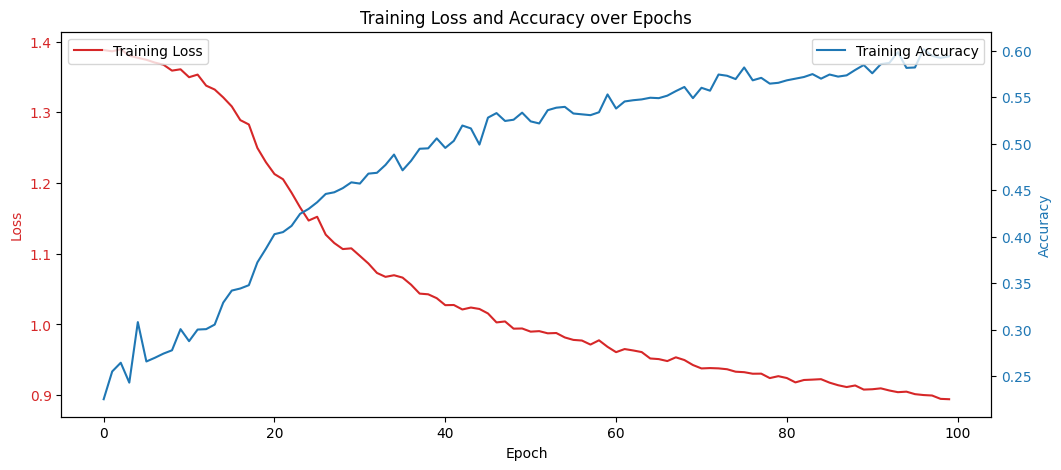

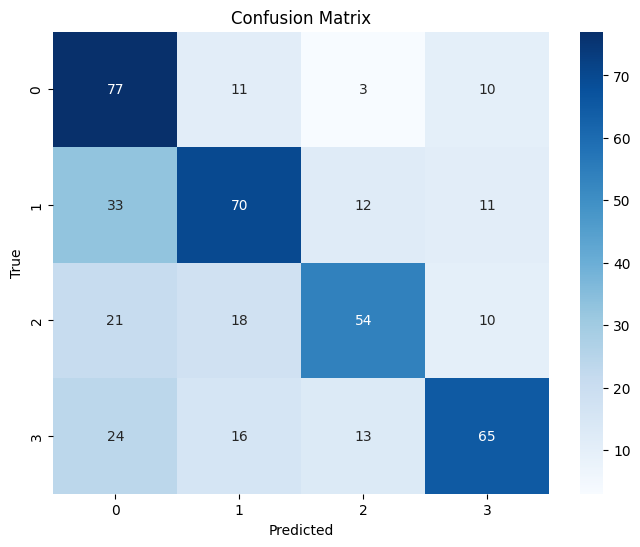

In [20]:
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import snntorch as snn
import torch.nn as nn
import torch.nn.functional as F
from snntorch import surrogate, utils
import snntorch.functional as SF
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # For CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data path
data_path = '/kaggle/input/spectrogram-extended-1'
batch_size = 32
num_classes = 4
num_steps = 20
beta = 0.3
spike_grad = surrogate.fast_sigmoid(slope=10)
learning_rate = 1e-3
n_epochs = 100

# Custom Dataset for Spectrogram Images
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all jpg files
        self.all_files = glob.glob(os.path.join(root_dir, '*.jpg'))

        # Mapping from label substring to integer
        self.class_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path = self.all_files[idx]

        # Extract label from filename
        filename = os.path.basename(img_path)
        g_index = filename.find('G')
        label_str = filename[g_index:g_index+2]  # e.g. 'G1'
        label = self.class_map[label_str]

        image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the entire dataset
full_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform)

# Determine the size of the training and testing sets (80% / 20% split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split dataset into training and testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Quick sanity check
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)  # [batch_size, 1, 128, 128]
    print("Targets shape:", targets.shape)
    break

# Define the SNN model
class SNN(nn.Module):
    def __init__(self, num_classes=4, beta=0.3, spike_grad=surrogate.fast_sigmoid(slope=10)):
        super(SNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Use PyTorch's standard Linear layer
        self.fc1 = nn.Linear(16 * 64 * 64, num_classes, bias=True)
        
        # Add a second LIF layer to handle spiking behavior after the Linear layer
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)  # [batch_size, 16, 64, 64]
        x, mem1 = self.lif1(x)  # Spiking behavior after convolution
        
        x = x.view(x.size(0), -1)  # Flatten [batch_size, 16*64*64]
        x = self.fc1(x)  # Linear transformation [batch_size, num_classes]
        x, mem2 = self.lif2(x)  # Spiking behavior after linear layer
        
        return x, mem2  # Return spike and membrane potential

# Initialize model, optimizer, and criterion
model = SNN(num_classes=num_classes, beta=beta, spike_grad=spike_grad).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = SF.ce_rate_loss()

# Define training functions
def forward_pass(input_data, model, num_steps):
    spk_rec = []
    mem_rec = []
    utils.reset(model)  # Reset the state of the model's SNN layers
    for _ in range(num_steps):
        spk, mem = model(input_data)  # Unpack spike and membrane potential
        spk_rec.append(spk)
        mem_rec.append(mem)
    return torch.stack(spk_rec), torch.stack(mem_rec)

def batch_acc(data_loader, model, num_steps):
    with torch.no_grad():
        model.eval()
        acc = 0
        total = 0
        for inputs, targets in iter(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            spk_rec, _ = forward_pass(inputs, model, num_steps)
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
    return acc / total

def evaluate(loader, model, num_steps):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():  # Disable gradient tracking
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            spk_rec, _ = forward_pass(images, model, num_steps)
            loss = criterion(spk_rec, labels)
            total_loss += loss.item()
            _, predicted = torch.max(spk_rec.sum(dim=0), 1)  # Sum spikes over timesteps
            total_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), total_correct / len(loader.dataset), all_preds, all_labels

# Main training loop
loss_history = []
acc_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    counter = 0
    acc_co = 0
    
    model.train()
    for inputs, targets in tqdm(iter(train_loader), desc=f"Epoch {epoch+1}/{n_epochs}"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        spk_rec, _ = forward_pass(inputs, model, num_steps)  # Collect spikes over timesteps
        loss = criterion(spk_rec, targets)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        counter += 1

        # Periodically check accuracy on test set
        if counter % 10 == 0:  # Adjust frequency as needed
            acc_val = batch_acc(test_loader, model, num_steps)
            train_acc += acc_val
            acc_co += 1

    train_loss = epoch_loss / counter
    train_acc = (train_acc / acc_co) if acc_co > 0 else 0
    loss_history.append(train_loss)
    acc_history.append(train_acc)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}') 

# Plotting accuracy and confusion matrix
def plot_metrics(train_loss, train_acc):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_loss, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(train_acc, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Training Loss and Accuracy over Epochs')
    plt.show()

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate on test set
test_loss, test_acc, val_preds, val_labels = evaluate(test_loader, model, num_steps)

# Plot metrics
plot_metrics(loss_history, acc_history)

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds)


In [1]:
!pip install snntorch
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import snntorch as snn
import torch.nn as nn
import torch.nn.functional as F
from snntorch import surrogate, utils
import snntorch.functional as SF
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # For CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data path
data_path = '/kaggle/input/spectrogram-extended-1'
batch_size = 32
num_classes = 4
num_steps = 200
beta = 0.2
spike_grad = surrogate.fast_sigmoid(slope=10)
learning_rate = 1e-3
n_epochs = 200

# Custom Dataset for Spectrogram Images
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all jpg files
        self.all_files = glob.glob(os.path.join(root_dir, '*.jpg'))

        # Mapping from label substring to integer
        self.class_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        img_path = self.all_files[idx]

        # Extract label from filename
        filename = os.path.basename(img_path)
        g_index = filename.find('G')
        label_str = filename[g_index:g_index+2]  # e.g. 'G1'
        label = self.class_map[label_str]

        image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust as needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the entire dataset
full_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform)

# Determine the size of the training and testing sets (80% / 20% split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split dataset into training and testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Quick sanity check
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)  # [batch_size, 1, 128, 128]
    print("Targets shape:", targets.shape)
    break

# Define the SNN model
class SNN(nn.Module):
    def __init__(self, num_classes=4, beta=0.3, spike_grad=surrogate.fast_sigmoid(slope=10)):
        super(SNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Use PyTorch's standard Linear layer
        self.fc1 = nn.Linear(16 * 64 * 64, num_classes, bias=True)
        
        # Add a second LIF layer to handle spiking behavior after the Linear layer
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)  # [batch_size, 16, 64, 64]
        x, mem1 = self.lif1(x)  # Spiking behavior after convolution
        
        x = x.view(x.size(0), -1)  # Flatten [batch_size, 16*64*64]
        x = self.fc1(x)  # Linear transformation [batch_size, num_classes]
        x, mem2 = self.lif2(x)  # Spiking behavior after linear layer
        
        return x, mem2  # Return spike and membrane potential

# Initialize model, optimizer, and criterion
model = SNN(num_classes=num_classes, beta=beta, spike_grad=spike_grad).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = SF.ce_rate_loss()

# Define training functions
def forward_pass(input_data, model, num_steps):
    spk_rec = []
    mem_rec = []
    utils.reset(model)  # Reset the state of the model's SNN layers
    for _ in range(num_steps):
        spk, mem = model(input_data)  # Unpack spike and membrane potential
        spk_rec.append(spk)
        mem_rec.append(mem)
    return torch.stack(spk_rec), torch.stack(mem_rec)

def batch_acc(data_loader, model, num_steps):
    with torch.no_grad():
        model.eval()
        acc = 0
        total = 0
        for inputs, targets in iter(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            spk_rec, _ = forward_pass(inputs, model, num_steps)
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
    return acc / total

def evaluate(loader, model, num_steps):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():  # Disable gradient tracking
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            spk_rec, _ = forward_pass(images, model, num_steps)
            loss = criterion(spk_rec, labels)
            total_loss += loss.item()
            _, predicted = torch.max(spk_rec.sum(dim=0), 1)  # Sum spikes over timesteps
            total_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), total_correct / len(loader.dataset), all_preds, all_labels

# Main training loop
loss_history = []
acc_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    counter = 0
    acc_co = 0
    
    model.train()
    for inputs, targets in tqdm(iter(train_loader), desc=f"Epoch {epoch+1}/{n_epochs}"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        spk_rec, _ = forward_pass(inputs, model, num_steps)  # Collect spikes over timesteps
        loss = criterion(spk_rec, targets)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        counter += 1

        # Periodically check accuracy on test set
        if counter % 10 == 0:  # Adjust frequency as needed
            acc_val = batch_acc(test_loader, model, num_steps)
            train_acc += acc_val
            acc_co += 1

    train_loss = epoch_loss / counter
    train_acc = (train_acc / acc_co) if acc_co > 0 else 0
    loss_history.append(train_loss)
    acc_history.append(train_acc)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}') 

# Plotting accuracy and confusion matrix
def plot_metrics(train_loss, train_acc):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_loss, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(train_acc, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Training Loss and Accuracy over Epochs')
    plt.show()

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate on test set
test_loss, test_acc, val_preds, val_labels = evaluate(test_loader, model, num_steps)

# Plot metrics
plot_metrics(loss_history, acc_history)

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.5 MB/s eta 0:00:00
Input shape: torch.Size([32, 1, 128, 128])
Targets shape: torch.Size([32])


Epoch 1/200: 100%|██████████| 58/58 [01:45<00:00,  1.83s/it]


Epoch [1/200], Loss: 1.3873, Accuracy: 0.2263


Epoch 2/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [2/200], Loss: 1.3792, Accuracy: 0.2379


Epoch 3/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [3/200], Loss: 1.3794, Accuracy: 0.2451


Epoch 4/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [4/200], Loss: 1.3697, Accuracy: 0.2522


Epoch 5/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [5/200], Loss: 1.3648, Accuracy: 0.2522


Epoch 6/200: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it]


Epoch [6/200], Loss: 1.3779, Accuracy: 0.2795


Epoch 7/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [7/200], Loss: 1.3597, Accuracy: 0.2812


Epoch 8/200: 100%|██████████| 58/58 [01:27<00:00,  1.52s/it]


Epoch [8/200], Loss: 1.3572, Accuracy: 0.2763


Epoch 9/200: 100%|██████████| 58/58 [01:29<00:00,  1.54s/it]


Epoch [9/200], Loss: 1.3488, Accuracy: 0.2656


Epoch 10/200: 100%|██████████| 58/58 [01:29<00:00,  1.54s/it]


Epoch [10/200], Loss: 1.3426, Accuracy: 0.2875


Epoch 11/200: 100%|██████████| 58/58 [01:29<00:00,  1.54s/it]


Epoch [11/200], Loss: 1.3392, Accuracy: 0.2920


Epoch 12/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [12/200], Loss: 1.3338, Accuracy: 0.3071


Epoch 13/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [13/200], Loss: 1.3325, Accuracy: 0.3009


Epoch 14/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [14/200], Loss: 1.3283, Accuracy: 0.3067


Epoch 15/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [15/200], Loss: 1.3192, Accuracy: 0.3085


Epoch 16/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [16/200], Loss: 1.3098, Accuracy: 0.3205


Epoch 17/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [17/200], Loss: 1.3098, Accuracy: 0.3384


Epoch 18/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [18/200], Loss: 1.2989, Accuracy: 0.3513


Epoch 19/200: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it]


Epoch [19/200], Loss: 1.2948, Accuracy: 0.3487


Epoch 20/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [20/200], Loss: 1.2851, Accuracy: 0.3442


Epoch 21/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [21/200], Loss: 1.2796, Accuracy: 0.3638


Epoch 22/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [22/200], Loss: 1.2741, Accuracy: 0.3750


Epoch 23/200: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it]


Epoch [23/200], Loss: 1.2651, Accuracy: 0.3812


Epoch 24/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [24/200], Loss: 1.2606, Accuracy: 0.3830


Epoch 25/200: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it]


Epoch [25/200], Loss: 1.2674, Accuracy: 0.3772


Epoch 26/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [26/200], Loss: 1.2553, Accuracy: 0.3804


Epoch 27/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [27/200], Loss: 1.2504, Accuracy: 0.3723


Epoch 28/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [28/200], Loss: 1.2685, Accuracy: 0.3741


Epoch 29/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [29/200], Loss: 1.2507, Accuracy: 0.3929


Epoch 30/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [30/200], Loss: 1.2394, Accuracy: 0.3879


Epoch 31/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [31/200], Loss: 1.2420, Accuracy: 0.3893


Epoch 32/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [32/200], Loss: 1.2627, Accuracy: 0.3652


Epoch 33/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [33/200], Loss: 1.2512, Accuracy: 0.3871


Epoch 34/200: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch [34/200], Loss: 1.2466, Accuracy: 0.3830


Epoch 35/200: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


Epoch [35/200], Loss: 1.2439, Accuracy: 0.3955


Epoch 36/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [36/200], Loss: 1.2309, Accuracy: 0.3973


Epoch 37/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [37/200], Loss: 1.2367, Accuracy: 0.3879


Epoch 38/200: 100%|██████████| 58/58 [01:27<00:00,  1.50s/it]


Epoch [38/200], Loss: 1.2276, Accuracy: 0.3951


Epoch 39/200:  93%|█████████▎| 54/58 [01:23<00:06,  1.55s/it]


KeyboardInterrupt: 

Input shape: torch.Size([16, 1, 128, 128])
Targets shape: torch.Size([16])
Output shape: torch.Size([16, 4])


100%|██████████| 117/117 [00:10<00:00, 10.95it/s]


Epoch [1/50], Loss: 1.4453, Train Acc: 0.2548, Val Acc: 0.2565


100%|██████████| 117/117 [00:10<00:00, 11.62it/s]


Epoch [2/50], Loss: 1.3864, Train Acc: 0.2569, Val Acc: 0.2457


100%|██████████| 117/117 [00:10<00:00, 11.34it/s]


Epoch [3/50], Loss: 1.3857, Train Acc: 0.2564, Val Acc: 0.2457


100%|██████████| 117/117 [00:09<00:00, 11.99it/s]


Epoch [4/50], Loss: 1.3839, Train Acc: 0.2596, Val Acc: 0.2349


100%|██████████| 117/117 [00:10<00:00, 11.64it/s]


Epoch [5/50], Loss: 1.3796, Train Acc: 0.3868, Val Acc: 0.3901


100%|██████████| 117/117 [00:10<00:00, 11.58it/s]


Epoch [6/50], Loss: 1.3184, Train Acc: 0.4135, Val Acc: 0.3815


100%|██████████| 117/117 [00:09<00:00, 12.42it/s]


Epoch [7/50], Loss: 1.2492, Train Acc: 0.4866, Val Acc: 0.4504


100%|██████████| 117/117 [00:10<00:00, 11.49it/s]


Epoch [8/50], Loss: 1.1600, Train Acc: 0.5443, Val Acc: 0.5431


100%|██████████| 117/117 [00:09<00:00, 12.15it/s]


Epoch [9/50], Loss: 1.0311, Train Acc: 0.6378, Val Acc: 0.5733


100%|██████████| 117/117 [00:09<00:00, 12.41it/s]


Epoch [10/50], Loss: 0.8501, Train Acc: 0.7869, Val Acc: 0.7371


100%|██████████| 117/117 [00:12<00:00,  9.55it/s]


Epoch [11/50], Loss: 0.6517, Train Acc: 0.8429, Val Acc: 0.7845


100%|██████████| 117/117 [00:17<00:00,  6.77it/s]


Epoch [12/50], Loss: 0.5166, Train Acc: 0.8531, Val Acc: 0.8039


100%|██████████| 117/117 [00:15<00:00,  7.57it/s]


Epoch [13/50], Loss: 0.3807, Train Acc: 0.9434, Val Acc: 0.8987


100%|██████████| 117/117 [00:14<00:00,  8.33it/s]


Epoch [14/50], Loss: 0.2838, Train Acc: 0.9562, Val Acc: 0.8858


100%|██████████| 117/117 [00:15<00:00,  7.31it/s]


Epoch [15/50], Loss: 0.1998, Train Acc: 0.9845, Val Acc: 0.9418


100%|██████████| 117/117 [00:19<00:00,  6.14it/s]


Epoch [16/50], Loss: 0.1420, Train Acc: 0.9872, Val Acc: 0.9332


100%|██████████| 117/117 [00:16<00:00,  7.20it/s]


Epoch [17/50], Loss: 0.0896, Train Acc: 0.9952, Val Acc: 0.9591


100%|██████████| 117/117 [00:13<00:00,  8.89it/s]


Epoch [18/50], Loss: 0.0554, Train Acc: 0.9973, Val Acc: 0.9698


100%|██████████| 117/117 [00:18<00:00,  6.41it/s]


Epoch [19/50], Loss: 0.0371, Train Acc: 0.9984, Val Acc: 0.9634


100%|██████████| 117/117 [00:15<00:00,  7.55it/s]


Epoch [20/50], Loss: 0.0252, Train Acc: 0.9995, Val Acc: 0.9677


100%|██████████| 117/117 [00:19<00:00,  6.04it/s]


Epoch [21/50], Loss: 0.0174, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:14<00:00,  7.85it/s]


Epoch [22/50], Loss: 0.0122, Train Acc: 0.9995, Val Acc: 0.9677


100%|██████████| 117/117 [00:13<00:00,  8.59it/s]


Epoch [23/50], Loss: 0.0093, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:13<00:00,  8.61it/s]


Epoch [24/50], Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:13<00:00,  8.46it/s]


Epoch [25/50], Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:10<00:00, 10.84it/s]


Epoch [26/50], Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:10<00:00, 10.77it/s]


Epoch [27/50], Loss: 0.0040, Train Acc: 1.0000, Val Acc: 0.9698


100%|██████████| 117/117 [00:09<00:00, 11.76it/s]


Epoch [28/50], Loss: 0.0031, Train Acc: 1.0000, Val Acc: 0.9698


100%|██████████| 117/117 [00:09<00:00, 12.19it/s]


Epoch [29/50], Loss: 0.0028, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:10<00:00, 11.57it/s]


Epoch [30/50], Loss: 0.0023, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.93it/s]


Epoch [31/50], Loss: 0.0021, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.24it/s]


Epoch [32/50], Loss: 0.0019, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.74it/s]


Epoch [33/50], Loss: 0.0016, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.04it/s]


Epoch [34/50], Loss: 0.0014, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.20it/s]


Epoch [35/50], Loss: 0.0013, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.89it/s]


Epoch [36/50], Loss: 0.0012, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.76it/s]


Epoch [37/50], Loss: 0.0011, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.35it/s]


Epoch [38/50], Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.91it/s]


Epoch [39/50], Loss: 0.0009, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.16it/s]


Epoch [40/50], Loss: 0.0008, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.25it/s]


Epoch [41/50], Loss: 0.0007, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:10<00:00, 11.67it/s]


Epoch [42/50], Loss: 0.0007, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 12.18it/s]


Epoch [43/50], Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.89it/s]


Epoch [44/50], Loss: 0.0005, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.92it/s]


Epoch [45/50], Loss: 0.0005, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:20<00:00,  5.71it/s]


Epoch [46/50], Loss: 0.0005, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:17<00:00,  6.71it/s]


Epoch [47/50], Loss: 0.0004, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:13<00:00,  8.76it/s]


Epoch [48/50], Loss: 0.0004, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.90it/s]


Epoch [49/50], Loss: 0.0004, Train Acc: 1.0000, Val Acc: 0.9677


100%|██████████| 117/117 [00:09<00:00, 11.85it/s]


Epoch [50/50], Loss: 0.0003, Train Acc: 1.0000, Val Acc: 0.9677


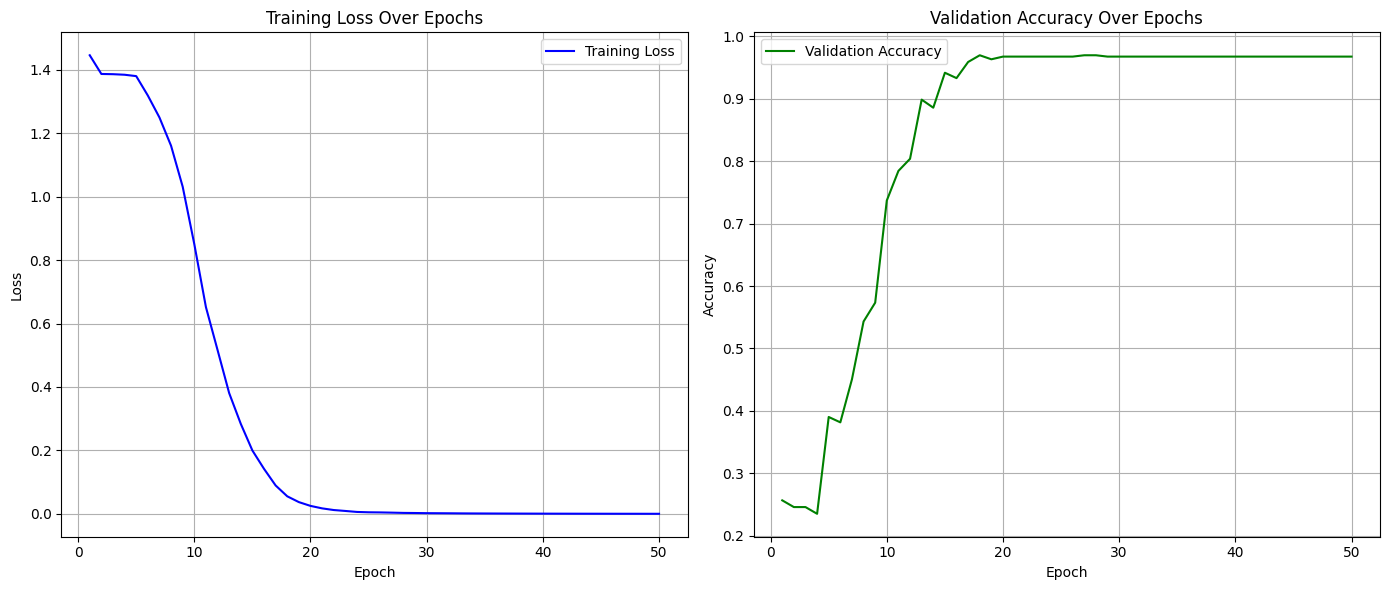

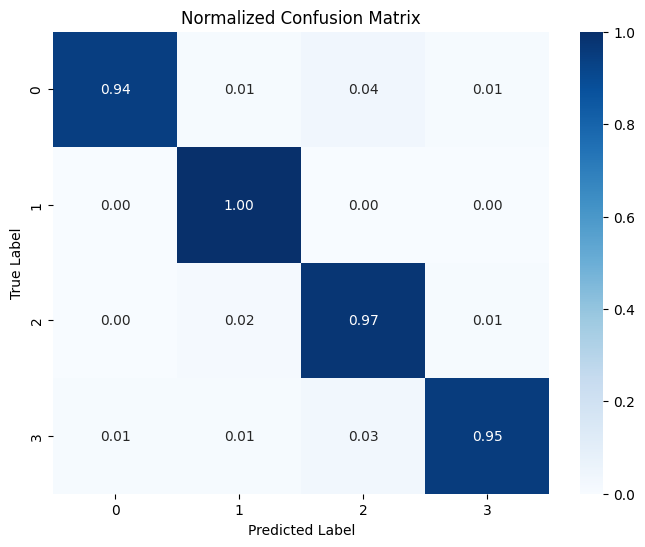

In [3]:
!pip install snntorch
import os
import glob
import random
import mne
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import snntorch as snn
from snntorch import spikegen, surrogate, utils
import snntorch.functional as SF
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger('mne').setLevel(logging.WARNING)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

# Data path
data_path = '/kaggle/input/spectrogram-extended-1'
batch_size = 16
num_classes = 4
x = 50
num_steps = x
beta = 0.3
spike_grad = surrogate.fast_sigmoid(slope=10)
learning_rate = 1e-3
n_epochs = x

class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, train_ratio=0.8, shuffle=True):
        self.root_dir = root_dir
        self.transform = transform

        # Gather all jpg files
        self.all_files = glob.glob(os.path.join(root_dir, '*.jpg'))

        if shuffle:
            random.shuffle(self.all_files)

        # Train/val split
        train_size = int(len(self.all_files) * train_ratio)
        if train:
            self.files = self.all_files[:train_size]
        else:
            self.files = self.all_files[train_size:]
        
        # Mapping from label substring to integer
        self.class_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]

        g_index = filename.find('G')
        label_str = filename[g_index:g_index+2]  # e.g. 'G1'
        
        label = self.class_map[label_str]

        from PIL import Image
        image = Image.open(img_path).convert('L')  # convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((64*2, 64*2)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform, train=True, train_ratio=0.8)
test_dataset = CustomSpectrogramDataset(root_dir=data_path, transform=transform, train=False, train_ratio=0.8)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)  
    print("Targets shape:", targets.shape)
    break

class MyEEGSNNModel(nn.Module):
    def __init__(self, n_outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc1 = nn.Linear(64 * 29 * 29, n_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), kernel_size=(2, 2))
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), kernel_size=(2, 2))
        spk2, mem2 = self.lif2(cur2, mem2)

        # Flatten
        batch_size_curr = x.shape[0]
        cur3 = self.fc1(spk2.view(batch_size_curr, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3

model = MyEEGSNNModel(num_classes).to(device)
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    spk_rec, mem_rec = utils.reset(model), None
    spk_test, mem_test = model(inputs)
    print("Output spk shape:", spk_test.shape) 
    break


def forward_pass(input_data, model, num_steps):
    spk_rec = []
    mem_rec = []
    utils.reset(model)
    for i in range(num_steps):
        spk, mem = model(input_data)
        spk_rec.append(spk)
        mem_rec.append(mem)
    return torch.stack(spk_rec), torch.stack(mem_rec)


def batch_acc(data_loader, model, num_steps):
    with torch.no_grad():
        model.eval()
        acc = 0
        total = 0
        for inputs, targets in iter(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            spk_rec, mem_rec = forward_pass(inputs, model, num_steps)
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
    return acc / total


criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

loss_history = []
acc_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    train_acc = 0.0
    counter = 0
    acc_co = 0
    
    model.train()
    for inputs, targets in tqdm(iter(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        spk_rec, _ = forward_pass(inputs, model, num_steps)
        loss = criterion(spk_rec, targets)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        counter += 1

        # Periodically check accuracy on test set
        if counter % 10 == 0:  # adjust frequency as needed
            acc_val = batch_acc(test_loader, model, num_steps)
            train_acc += acc_val
            acc_co += 1

    train_loss = epoch_loss / counter
    train_acc = (train_acc / acc_co) if acc_co > 0 else 0
    loss_history.append(train_loss)
    acc_history.append(train_acc)
    print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

# Plotting training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_history, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot for validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all predictions and actual labels
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
